<a href="https://colab.research.google.com/github/chless/arxiv-course-rl/blob/2022-UNIST/01_Value_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value Iteration

#### Import Library

In [ ]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print ("plt version:[{}]".format(matplotlib.__version__))
print ("gym version:[{}]".format(gym.__version__))

plt version:[3.2.2]
gym version:[0.17.3]


---

### FrozenLake Environment

In [ ]:
env = gym.make('FrozenLake-v0')
obs_space = env.observation_space
n_state = obs_space.n
action_space = env.action_space
n_action = action_space.n
print("Observation space:[{}]".format(n_state))
print("Action space:[{}]".format(n_action))
env.render()

Observation space:[16]
Action space:[4]

SFFF
FHFH
FFFH
HFFG


State
- S : starting point, safe
- F : frozen surface, safe
- H : hole, fall to your doom
- G : goal, where the frisbee is located

Action
- LEFT : 0
- DOWN : 1
- RIGHT : 2
- UP : 3

---

### Helper functions

#### State visualize function

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_matrix(M,strs='',
                     fontsize=15,
                     cmap='turbo',
                     title='Title',
                     title_fs=15,
                     REMOVE_TICK_LABELS=True):
    """
    Visualize a matrix colors and strings 
    """
    
    n_row,n_col = M.shape[0],M.shape[1]
    fig,ax = plt.subplots()
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    plt.show()

#### Value visualize function

In [ ]:
def plot_pi_v(Pi,V,
              title='Value Function',
              cmap='viridis',
              title_fs=15,
              REMOVE_TICK_LABELS=True):
    """
    Visualize pi and V
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = V.shape[0],V.shape[1]
    fig,ax = plt.subplots()
    divider = make_axes_locatable(ax)
    im = ax.imshow(V,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0))
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    arr_len = 0.2
    for i in range(4):
        for j in range(4):
            s = i*4+j
            if Pi[s][0]> 0: plt.arrow(j+0.5,i+0.5,-arr_len,0,
                          color="r",alpha=Pi[s][0],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0: plt.arrow(j+0.5,i+0.5,0,arr_len,
                          color="r",alpha=Pi[s][1],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0: plt.arrow(j+0.5,i+0.5,arr_len,0,
                          color="r",alpha=Pi[s][2],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0: plt.arrow(j+0.5,i+0.5,0,-arr_len,
                          color="r",alpha=Pi[s][3],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    plt.show()

---

### Initialize state

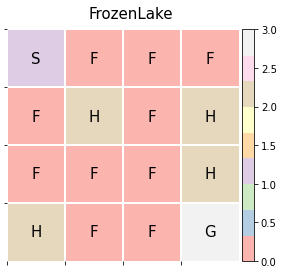

In [ ]:
M = np.zeros(shape=(4,4))
strs = ['S','F','F','F',
        'F','H','F','H',
        'F','F','F','H',
        'H','F','F','G',]
M[0,0] = 1 # Start
M[1,1]=M[1,3]=M[2,3]=M[3,0]=2 # Hole
M[3,3] = 3 # Goal
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake')



---



### Value iteration
$
V_{k+1}(s) = \max_a \sum_{s'}
\left[
r(s,a,s') + \gamma V_k(s')
\right]
P(s'|s,a)
$

or

$
Q_k(s,a) = \sum_{s'}
\left[
r(s,a,s') + \gamma V_k(s')
\right]
P(s'|s,a)
$
and
$
V_{k+1}(s) = \max_{a'} Q_k(s,a')
$

In [ ]:
def value_iteration(env,gamma=0.99,eps=1e-6):
    # Extract the world information
    n_state = env.observation_space.n
    n_action = env.action_space.n
    
    # Transition probability
    # P[state][action] = [(prob, next state, reward, done), ...]
    P = env.unwrapped.P
    
    # Initialize value
    V = np.random.uniform(size=(n_state,1)) # [n_state x 1]
    
    # Loop 
    tick,V_dists,V_list,Q_list = 0,[],[],[]
    while True:
        tick = tick + 1
        Q = np.zeros(shape=(n_state,n_action)) # [n_state x n_action]
        for s in P.keys(): # for all states s
            for a in P[s].keys(): # for all actions a
                for prob, s_prime, reward, done in P[s][a]:
                    Q[s,a] += (reward + gamma*V[s_prime])*prob
        V_prime = np.max(Q,axis=1) # [n_state x 1]
        V_dist = np.max(np.abs(V-V_prime))
        V_dists.append(V_dist)
        V = V_prime # update
        V_list.append(V)
        Q_list.append(Q)
        if V_dist < eps:
            break
    return Q,V,V_dists,V_list,Q_list

### Run value iteration

In [ ]:
import time
start = time.time()
Q,V,V_dists,V_list,Q_list = value_iteration(env,gamma=0.99,eps=1e-6)
print("It took [{:.2f}]s.".format(time.time()-start))
print ("Value Iteraction converged in [{}] loops.".format(len(V_dists)))

It took [0.17]s.
Value Iteraction converged in [881] loops.


#### Compute the optimal policy and plot 

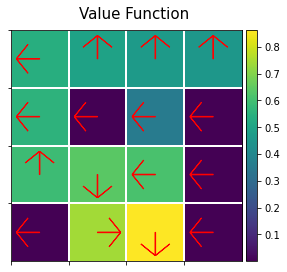

In [ ]:
Pi = np.zeros((n_state,n_action))
Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
plot_pi_v(Pi,np.reshape(V,(4,4)))

#### Plot the convergence of value iteration

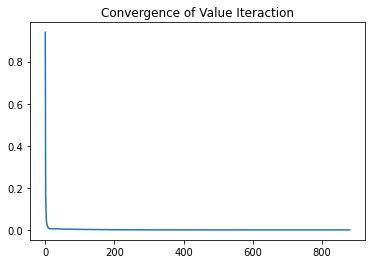

In [ ]:
plt.plot(V_dists)
plt.title("Convergence of Value Iteraction")
plt.show()

### Plot how the value function changes over iteration

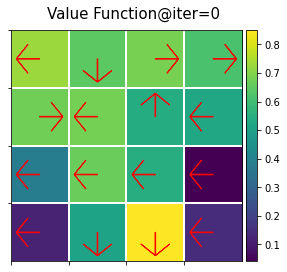

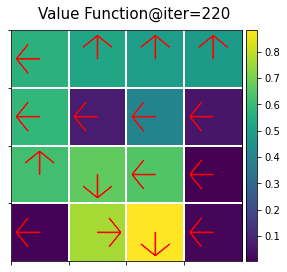

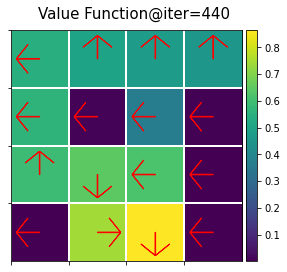

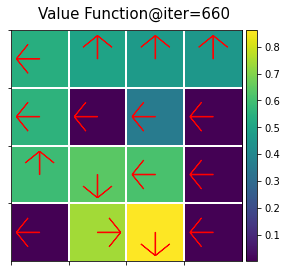

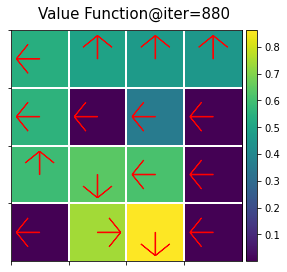

In [ ]:
n_plot = 5
for itr in np.round(np.linspace(0,len(Q_list)-1,n_plot)).astype(np.int32):
    V,Q = V_list[itr],Q_list[itr]
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
    plot_pi_v(Pi,np.reshape(V,(4,4)),title="Value Function@iter={}".format(itr))

### Plot the value functions of different $\gamma$s

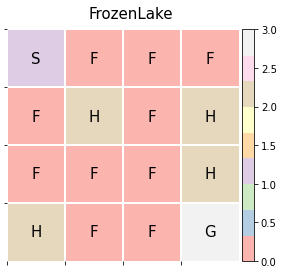

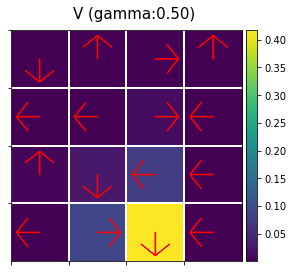

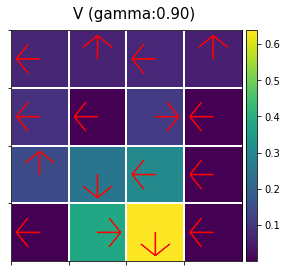

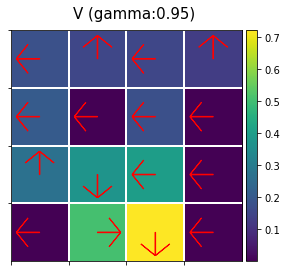

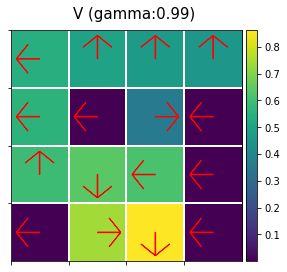

In [ ]:
visualize_matrix(M,strs=strs,cmap='Pastel1',title='FrozenLake')
for gamma in [0.5,0.9,0.95,0.99]:
    Q,V,V_dists,V_list,Q_list = value_iteration(env,gamma=gamma,eps=1e-6)
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
    plot_pi_v(Pi,np.reshape(V,(4,4)),title='V (gamma:{:.2f})'.format(gamma))

### Run with the optimal policy

In [ ]:
gamma = 0.99
Q,V,V_dists,V_list,Q_list = value_iteration(env,gamma=gamma,eps=1e-6)
Pi = np.zeros((n_state,n_action))
Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1
# Initialize environment
env = gym.make('FrozenLake-v0')
obs = env.reset() # reset
ret = 0
for tick in range(1000):
    print("\n tick:[{}]".format(tick))
    env.render(mode='human')
    action = np.random.choice(n_action,1,p=Pi[obs][:])[0] # select action
    next_obs,reward,done,info = env.step(action)
    obs = next_obs
    ret = reward + gamma*ret 
    if done: break
env.render(mode='human')
env.close()
print ("Return is [{:.3f}]".format(ret))


 tick:[0]

SFFF
FHFH
FFFH
HFFG

 tick:[1]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[2]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[3]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[4]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[5]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[6]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[7]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[8]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[9]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[10]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[11]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[12]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[13]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[14]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[15]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[16]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[17]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[18]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[19]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[20]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[21]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[22]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[23]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[24]
  (Left)
SFFF
FHFH
FFFH
HF

### Run with the random policy

In [ ]:
env = gym.make('FrozenLake-v0')
obs = env.reset() # reset
ret = 0
for tick in range(1000):
    print("\n tick:[{}]".format(tick))
    env.render(mode='human')
    action = env.action_space.sample()
    next_obs,reward,done,info = env.step(action)
    obs = next_obs
    ret = reward + gamma*ret 
    if done: break
env.render(mode='human')
env.close()
print ("Return is [{:.3f}]".format(ret))


 tick:[0]

SFFF
FHFH
FFFH
HFFG

 tick:[1]
  (Right)
SFFF
FHFH
FFFH
HFFG

 tick:[2]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[3]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[4]
  (Right)
SFFF
FHFH
FFFH
HFFG

 tick:[5]
  (Right)
SFFF
FHFH
FFFH
HFFG

 tick:[6]
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
Return is [0.000]
